In [1]:
import tensorflow as tf

### To confirm if the gpu got detected

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
import os

In [4]:
datapath = "../../../../datasets/covidDataset"
print(os.path.exists(datapath))

True


In [5]:
import pathlib
def get_imagepath_and_labels(datapath):
    data_root = pathlib.Path(datapath)
    all_image_path = [str(path) for path in list(data_root.glob('*/*'))]
    all_image_label = [pathlib.Path(single_image_path).parent.name for single_image_path in all_image_path]

    return all_image_path, all_image_label

all_image_path, all_image_label = get_imagepath_and_labels(datapath)

In [6]:
import numpy as np

def get_images_and_labels_astensor(image_path, image_labels, target_size, channels):
    '''
    target_size is to resize the image.
    '''
    images = []
    labels = []
    for i in range(0, len(image_path)):
        image = image_astensor(image_path[i], target_size, channels=channels)
        images.append(image)
        labels.append(image_labels[i])
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def image_astensor(image_path, target_size, channels):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=channels)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32 )
        image = image / 255
        return image

target_size = (224, 224)
cahnnels = 3
images, labels = get_images_and_labels_astensor(all_image_path, all_image_label, target_size, channels=3)
print(images.shape)
print(labels.shape)

(2481, 224, 224, 3)
(2481,)


In [7]:
print(np.unique(labels, return_counts=True))

(array(['COVID', 'non-COVID'], dtype='<U9'), array([1252, 1229]))


In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    labels, 
    test_size=400, 
    shuffle=True,
    random_state=42,
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=282, 
    shuffle=True,
    random_state=42,
)
y_valid = np.expand_dims(y_valid, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(1799, 224, 224, 3)
(1799, 1)
(400, 224, 224, 3)
(400, 1)
(282, 224, 224, 3)
(282, 1)


In [9]:
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))    

(array(['COVID', 'non-COVID'], dtype='<U9'), array([150, 132]))
(array(['COVID', 'non-COVID'], dtype='<U9'), array([892, 907]))
(array(['COVID', 'non-COVID'], dtype='<U9'), array([210, 190]))


In [10]:
from sklearn.preprocessing import LabelEncoder
# prepare target

def prepare_targets(y_train, y_test, y_valid):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    y_valid_enc = le.transform(y_valid)
    return y_train_enc, y_test_enc, y_valid_enc

y_train_enc, y_test_enc, y_valid_enc = prepare_targets(y_train, y_test, y_valid)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
print(y_train[110])
print(y_train_enc[110])
print(y_test[110])
print(y_test_enc[110])
print(y_valid[110])
print(y_valid_enc[110])

['COVID']
0
['non-COVID']
1
['non-COVID']
1


In [12]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_enc, 2)
y_test_cat = to_categorical(y_test_enc, 2)
y_valid_cat = to_categorical(y_valid_enc, 2)

In [13]:
print(y_train[110])
print(y_train_enc[110])
print(y_train_cat[110])
print("\n")
print(y_test[110])
print(y_test_enc[110])
print(y_test_cat[110])
print("\n")
print(y_valid[110])
print(y_valid_enc[110])
print(y_valid_cat[110])

['COVID']
0
[1. 0.]


['non-COVID']
1
[0. 1.]


['non-COVID']
1
[0. 1.]


In [14]:
import matplotlib.pyplot as plt

# to suppress warnings
import warnings
warnings.filterwarnings('ignore')

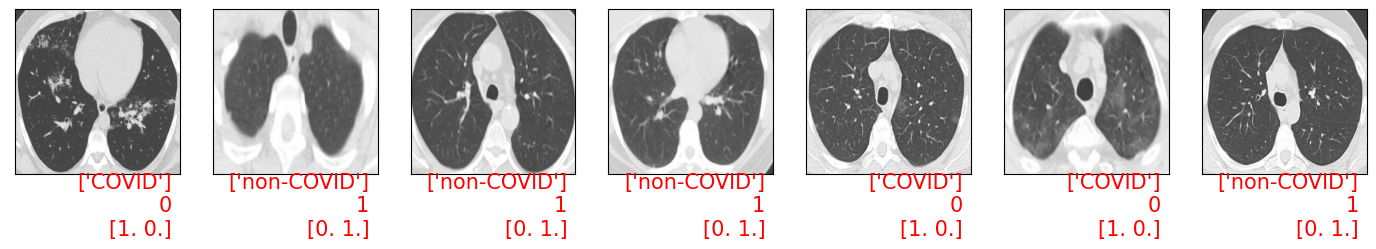

In [15]:
n = 8
plt.figure(figsize=(20, 4))

for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train[i])
    ax.text(0.95, 0.01, "{0}\n{1}\n{2}".format(y_train[i], y_train_enc[i], y_train_cat[i]),
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='red', fontsize=15)
#     ax.title.set_text(y_train_cat[i], "\n", y_train_enc[i])
#     ax.title.set_text(y_train_enc[i])
#     ax.title.set_text(y_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(type(train_generator))

In [16]:
def plot_accuracy_and_loss(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## part 1 - Output 1

In [17]:
# import keras

vgg_model = tf.keras.applications.VGG19(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3))
# vgg_model.summary()
vgg_model.trainable=False 

x = vgg_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.Model(vgg_model.input, output)
vgg._name='vgg19'
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
model_checkpoint_path = 'models/test3/vgg19'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [19]:
vgg.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

vgg_history = vgg.fit(X_train[:32], y_train_cat[:32],
                    epochs=1,
                      batch_size=8,
                    validation_data=(X_valid[:32], y_valid_cat[:32]),
                       callbacks=[model_checkpoint_callback])

4/4 [==============================] - 43s 6s/step - loss: 3.4489 - binary_accuracy: 0.3438 - val_loss: 0.8798 - val_binary_accuracy: 0.4375


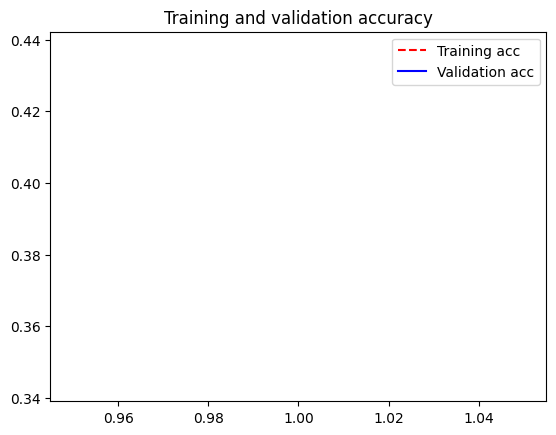

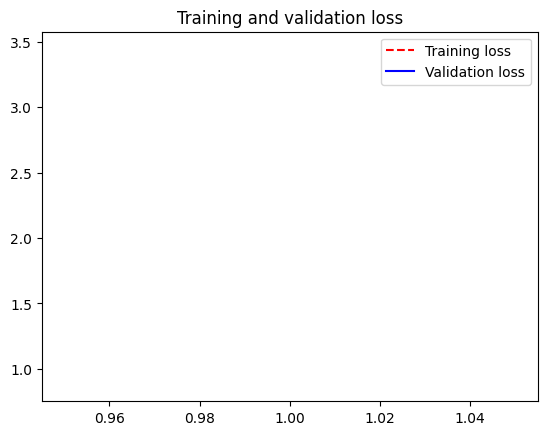

In [20]:
plot_accuracy_and_loss(vgg_history)

In [21]:
test_loss, test_acc = vgg.evaluate(X_test, y_test_cat)
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

13/13 [==============================] - 41s 2s/step - loss: 0.8413 - binary_accuracy: 0.4750
Accuracy: 0.4749999940395355
Loss:  0.8413118124008179


## Part 2 - DenseNet 169

In [22]:
dense169_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model.trainable=False 

x = dense169_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

densenet_1 = tf.keras.Model(dense169_model.input, output)
densenet_1._name='densenet_1'
densenet_1.summary()

Model: "densenet_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                         

                                                                                                  
 conv5_block2_0_relu (Activatio  (None, 7, 7, 672)   0           ['conv5_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 128)    86016       ['conv5_block2_0_relu[0][0]']    
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [23]:
model_checkpoint_path = 'models/test3/densenet-1000'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [24]:
print(len(densenet_1.layers))

600


In [25]:
densenet_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_1_history = densenet_1.fit(X_train[:32], y_train_cat[:32],
                    epochs=1,
                    batch_size=16,
                    validation_data=(X_valid[:32], y_valid_cat[:32]),
                  callbacks=[model_checkpoint_callback])

2/2 [==============================] - 461s 441s/step - loss: 21.7046 - binary_accuracy: 0.5312 - val_loss: 33.0787 - val_binary_accuracy: 0.5625


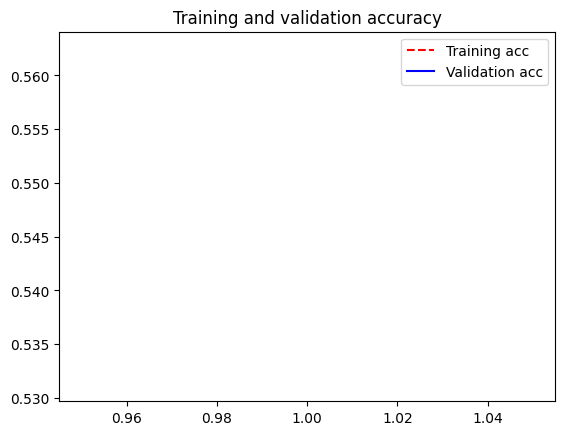

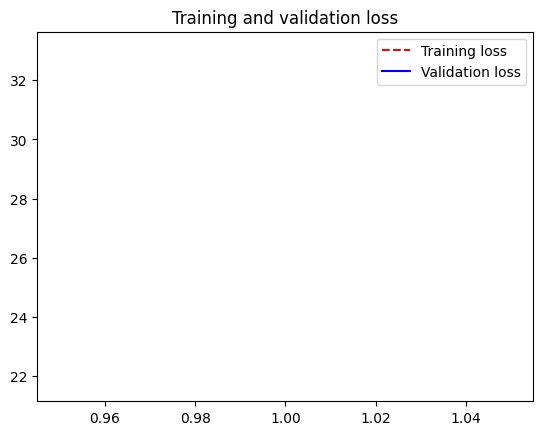

In [26]:
plot_accuracy_and_loss(densenet_1_history)

In [27]:
test_loss, test_acc = densenet_1.evaluate(X_test[:32], y_test_cat[:32])
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

1/1 [==============================] - 66s 66s/step - loss: 34.9077 - binary_accuracy: 0.5000
Accuracy: 0.5
Loss:  34.90765380859375


## DenseNet 169 - Output2

In [30]:
# since the model is already loaded we load in again
x = dense169_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

densenet_2 = tf.keras.Model(dense169_model.input, output)
densenet_2._name='densenet_2'
densenet_2.summary()

Model: "densenet_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                         

                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_concat (Concaten  (None, 14, 14, 960)  0          ['conv4_block21_concat[0][0]',   
 ate)                                                             'conv4_block22_2_conv[0][0]']   
                                                                                                  
 conv4_block23_0_bn (BatchNorma  (None, 14, 14, 960)  3840       ['conv4_block22_concat[0][0]']   
 lization)

In [31]:
model_checkpoint_path = 'models/test2/densenet-1000-500-200'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [32]:
densenet_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_2_history = densenet_2.fit(X_train[:32], y_train_cat[:32],
                    epochs=1,
                    batch_size = 16,
                    validation_data=(X_valid[:32], y_valid_cat[:32]),
                              callbacks=[model_checkpoint_callback])

ResourceExhaustedError:  OOM when allocating tensor with shape[81536,1000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/densenet_2/dense_6/MatMul/MatMul_1
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_169596]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/densenet_2/dense_6/MatMul/MatMul_1:
In[0] densenet_2/dropout_6/dropout/Mul_1 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/core/dropout.py:105)	
In[1] gradient_tape/densenet_2/dense_6/ReluGrad:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-32-43467a280b3d>", line 7, in <module>
>>>     densenet_2_history = densenet_2.fit(X_train[:32], y_train_cat[:32],
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

In [ ]:
plot_accuracy_and_loss(densenet_2_history)

In [ ]:
test_loss, test_acc = densenet_2.evaluate(X_test[:32], y_test_cat[:32])
print('Accuracy:', test_acc)
print('Loss: ', test_loss)

## Final Step - Stacking

In [ ]:
vgg = tf.keras.models.load_model('models/test3/vgg19')
densenet_1 = tf.keras.models.load_model('models/test3/densenet-1000')
densenet_2 = tf.keras.models.load_model('models/test3/densenet-1000-500-200')

In [ ]:
vgg.trainable = False
densenet_1.trainable = False
densenet_2.trainable = False
models = [vgg, densenet_1, densenet_2]
# to avoid conflicts with naming
for layer in models[0].layers:
    layer._name = layer.name + str('_0')
for layer in models[1].layers:
    layer._name = layer.name + str('_1')
for layer in models[2].layers:
    layer._name = layer.name + str('_2')

In [ ]:
y1 = vgg.output
y2 = densenet_1.output
y3 = densenet_2.output
average = tf.keras.layers.Average()([y1, y2, y3])
output = tf.keras.layers.Dense(1, activation='softmax')(average)

ensembled = keras.Model([vgg.input, densenet_1.input, densenet_2.input], output)

ensembled.summary() 

In [ ]:
ensembled.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
# from tf.keras.utils.vis_utils import plot_model
# tf.keras.utils.plot_model(ensembled, to_file='models/test2/ensembled.png')

In [ ]:
model_checkpoint_path = 'models/test3/ensembled'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [ ]:
ensembled_history = ensembled.fit(x = [X_train[:32], X_train[:32], X_train[:32] ],y = y_train_cat[:32],
                    epochs=1,
                    validation_data=([X_valid[:32], X_valid[:32], X_valid[:32]], y_valid_cat[:32]),
                              callbacks=[model_checkpoint_callback],
                                  batch_size = 16)

In [ ]:
plot_accuracy_and_loss(ensembled_history)

In [ ]:
test_loss, test_acc = ensembled.evaluate(X_test[:32], y_test_cat[:32])
print('Accuracy:', test_acc)
print('Loss: ', test_loss)